# Reinforcement Learning: Taxi Driver Problem

In this notebook we will learn about reinforcement learning using [Open AI Gym's Taxi environment](https://gym.openai.com/envs/Taxi-v3/). Read over the description in the link so that you understand the environment.

This environment is slightly more challenging, and in this notebook we will focus on a new method of reinforcement learning called Q-Learning to help us solve it.

We start by importing the necessary modules and creating the environment.

In [1]:
# !pip install --upgrade gym==0.17.3
import gym
import time

env = gym.make('Taxi-v3')
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



> Note: your environment may look slightly different, it is randomly generated each time.

In this environment, the agent's goal is to go to the location of the blue letter, pickup the person waiting there, and drop them off at the location of the purple letter.

Presumably the actions available are North, South, West, East, Dropoff and Pickup. There are also illegal pickup and dropoff actions for which we receive a 10 point penalty.

However, we as the reinforcement learning programmers shouldn't care about any of this. It is our job to make an algorithm that can figure out the rules of the world on its own!

In [2]:
env.nS, env.nA

(500, 6)

As you can see, there are far more states and two more actions than the Frozen Lake environment!

Our previous algorithm for solving the Frozen Lake environment is very inefficient and would take too long when given more states and actions like this.

On top of that, it is also unrealistic! It relies on us having access to knowledge about the entire environment ahead of time: we use `env.P` to find out what the next states and their probabilities are for any given state before we even step onto the lake! This is not ideal for a reinforcement learning algorithm; our agent should be able to learn how to reach its goal using only trial and error.

For example, take a robot that is learning to move around a room with reinforcement learning. There is no way we could possibly predict ahead of time every possible result of every action, the robot would have to learn by trying in its environment!

So we need to figure out a better way...

One way to solve this environment is to just pick a random action until we reach the goal.

In [3]:
state = env.reset()
counter = 0
reward = None
while reward != 20:
    state, reward, done, info = env.step(env.action_space.sample())
    counter += 1

print(counter)

3775


This method is inefficient though. Even on the off chance that we take under 1000 actions, this is still far too many!

## Q-Learning

We need an algorithm to help our agent make smarter decisions: Q-Learning.

Q-Learning involves generating a table of values for every state and action. The states are the rows and the actions are the columns. Each cell of the table will represent how good it is to take an action in a given state, and the "learning" comes in as we update these values from experience!

We make updates using the *Bellman Equation*, which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. The equation is as follows:

$$
Q(s,a) = r + \gamma * \max(Q(s'))
$$

We use this equation to update the table each time we take an action and "gain experience".

Here, $Q(s,a)$ refers to the cell in the table which represents action $a$ at state $s$. In NumPy, this would be `Q[s, a]`.

$s$ and $a$ represent the state we were just in and the action we took. $s'$ represents the state that we moved to after taking action $a$.

$r$ represents the reward we received for moving to state $s'$.

So what this equation is saying is: the value of the action we just took from the state we were just in (the cell at $Q(s, a)$) is calculated by adding the reward with the best possible action for the state we transferred to ($\max(Q(s'))$).

$\gamma$ is the discount factor, which is a number that we choose ahead of time. We adjust this value to make our algorithm work better, and it effectively represents how much weight we give to the next best action while we're making our decision about the action we just took.

In [4]:
import numpy as np

def qlearn(gamma):
    Q = np.zeros((env.nS, env.nA))
    
    rewards = []
    best_reward = 0
    best_episode = []
    num_episodes = 1000
    
    for i in range(num_episodes):
        episode = []
        done = False
        episode_reward = 0
        state = env.reset()
        while not done:
            #1
            value_noise = np.random.randn(1, env.nA)*(1./(i+1))
            action = np.argmax(Q[state] + value_noise)
            next_state, reward, done, _ = env.step(action) #2
            Q[state,action] = reward + gamma * np.max(Q[next_state]) #3
            episode_reward += reward
            state = next_state
            episode.append(env.render(mode='ansi'))
        # if (i+1) % 50 == 0:
            # print(f'Episode {i + 1} Reward: {episode_reward}')
    
        # We save this episode if we reached the goal in fewer steps
        if episode_reward > best_reward:
            best_episode = episode
    
        rewards.append(episode_reward)

    return rewards, best_episode

rewards, best_episode = qlearn(0.95)
print('Average reward for first 100 episodes:', np.mean(rewards[:100]))
print('Average reward for last 100 episodes:', np.mean(rewards[-100:]))

Average reward for first 100 episodes: -178.64
Average reward for last 100 episodes: 8.11


So we start by initializing our table to have a row for each state and a column for each action. Then we give our agent `num_episodes` attempts to learn from the environment and update the table. Along the way we also keep track of the reward for each episode. Within each episode we:

1. Choose an action by finding the maximum value for our current state. We use `np.argmax` to get the *index* of this maximum value.

 We also throw in some random noise to try to get our agent to try different actions occasionally, instead of always just picking the best. `np.randn` here will give us a list of random numbers, one number for each state. We then multiply by $\frac{1}{i+1}$, which reduces the noise as our model gains more experience and we start to prioritize optimization over experimentation.

2. We take our chosen action and observe the results: the next state, the reward we received, and whether or not we are done.

3. We update the "goodness" of the action we just took in the state we were just in using the Bellman Equation.

In [9]:
from google.colab import output

for e in best_episode:
    output.clear()
    print(e)
    time.sleep(0.7)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



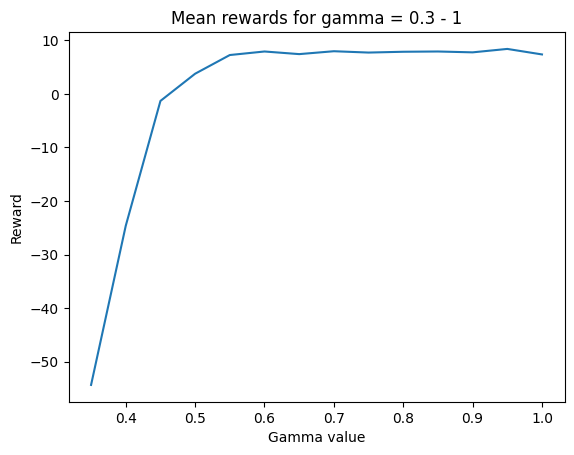

In [10]:
mean_rewards = dict()

for x in np.arange(1, 0.30, -0.05):
    rewards, _ = qlearn(x)
    mean_rewards[x] = np.mean(rewards[-100:])
    
import matplotlib.pyplot as plt

myList = mean_rewards.items()
x, y = zip(*myList) 

plt.plot(x, y)
plt.xlabel('Gamma value')
plt.ylabel('Reward')
plt.title('Mean rewards for gamma = 0.3 - 1')
plt.show()

## Exploration vs Exploitation

Let's examine the results of using exploration and exploitation with our agent.

In [5]:
%matplotlib inline

In order to lean our agent more towards exploration or exploitation, we can change `gamma`.

The higher `gamma` is, the more the agent will exploit because it will give more weight to previous valuations of the states.

The lower `gamma` is, the more the agent will explore because it will give less weight to previous valuations of the states.

In [6]:
from matplotlib import pyplot as plt  

exploit_rewards, _ = qlearn(1)
explore_rewards, _ = qlearn(0.4)

If we look at the standard deviation of both reward lists, the explore rewards will likely have a greater deviation as it is trying new things and receiving varied rewards.

In [7]:
import numpy as np
print(np.std(exploit_rewards))
print(np.std(explore_rewards))

84.79405355919718
95.70971314866638


If we plot the rewards over time, we can see this deviation more clearly.

With exploration, we are always trying new actions and never really deciding on a single policy, so we see varying rewards throughout all episodes.

With exploitation, we still try new things, but eventually arrive at a single strategy and stick with it, so near the end the rewards start to stay about the same.

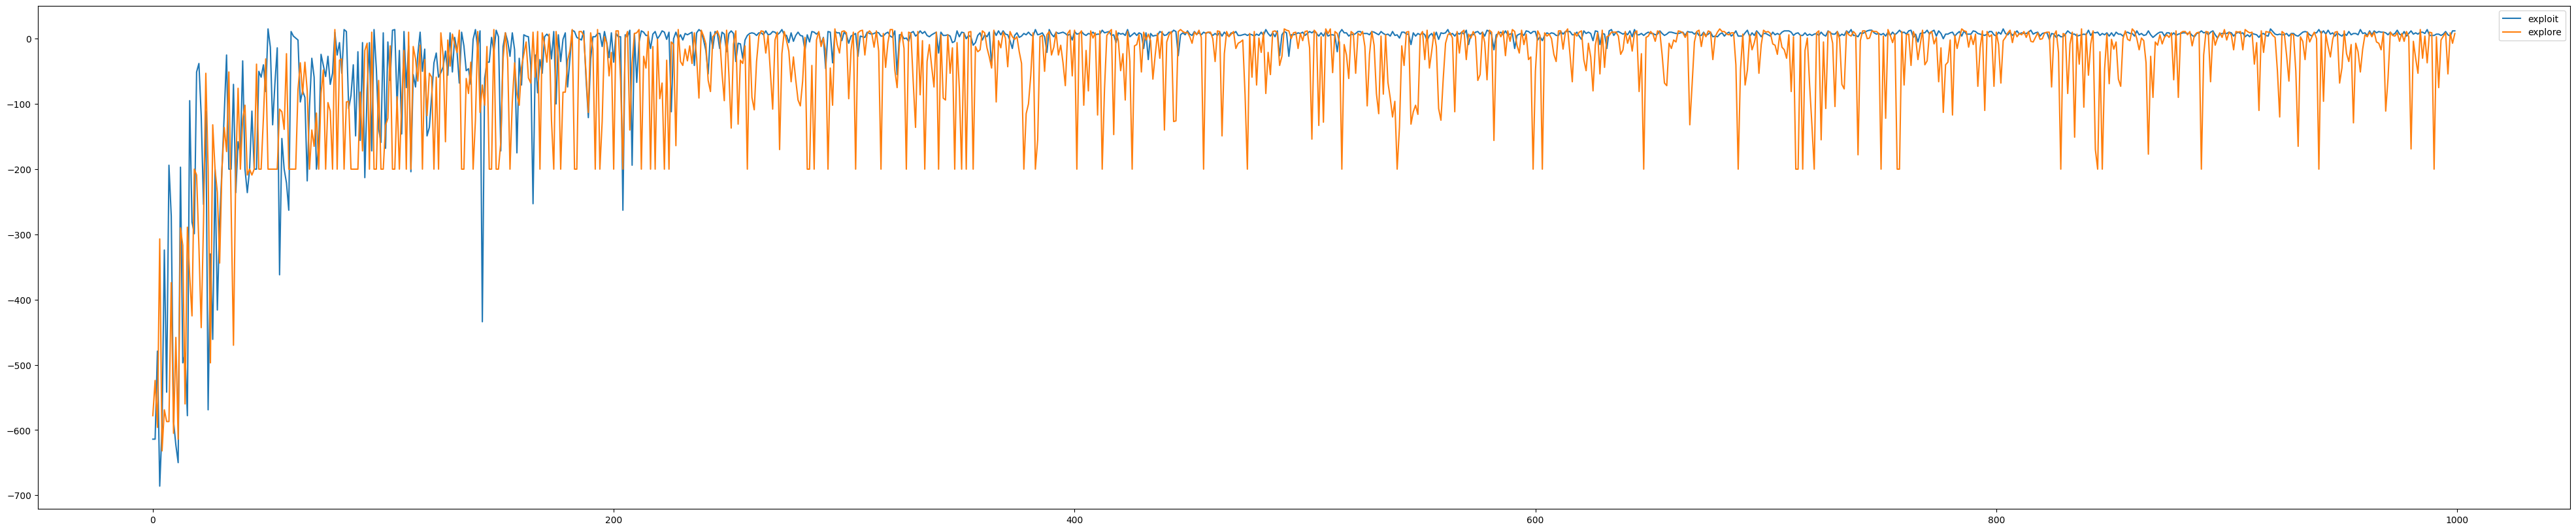

In [8]:
def plot_rewards(r, label):
    x = list(range(len(r)))
    plt.plot(x, r, label=label)

f = plt.figure() 
f.set_figwidth(50) 
f.set_figheight(10)

plot_rewards(exploit_rewards, 'exploit')
plot_rewards(explore_rewards, 'explore')
plt.legend()

plt.show()

Even though in this problem it seems like the exploitation strategy has worked better because it found an optimal strategy sooner, it is still important to consider exploration as well. If you exploit too much, the agent could get stuck on a sub-optimal strategy because it is "afraid" to try new things.

## Sources

- Based on [this article](https://www.oreilly.com/radar/introduction-to-reinforcement-learning-and-openai-gym/)
- https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0
- https://www.manifold.ai/exploration-vs-exploitation-in-reinforcement-learning